## Feature Extraction - Standard Working Version 
This script processes the summer data+ team's figshare imagery for feature extraction.  
In particular, it isolates the VIIRS band (#48) and calculates multiple statistics from this
as features/columns in a new dataframe for input into basic ML models to predict electrification
rates in Bihar, India.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import math
from skimage import io
import re

# Import Feature List- this is a Python file- feature_list.py! Must be in same directory as this .ipynb file. 
from feature_list import feature_labels

In [6]:
print ('There are {} features indicated for extraction. To add more, edit feature_list.py.'.format(len(feature_labels)))

There are 338 features indicated for extraction. To add more, edit feature_list.py.


In [7]:
"""
This first code block takes the VIIRS imagery and binary masks as inputs.
Output is a csv with each village's extracted features.
"""
VIIRS_IMAGE_PATH = "./indian_village_dataset/imagery_res30_48bands/"
MASK_IMAGE_PATH = "./indian_village_dataset/masks_res30/"
dict = {}

files = [file for file in os.listdir(MASK_IMAGE_PATH) if file.endswith('.tif')] 
#files = np.random.choice(files, 10) # uncomment for testing 

print('Initialized file reading.')
counter_invalid, id_invalid, error_image = 0, 0, 0
for file in files:
    # load image
    try: 
        im = io.imread(VIIRS_IMAGE_PATH + file)
        # check for numbers in filename 
        regexp = re.search('([0-9])\w+', file)
        # check for invalids  
        if im.shape[2] < 47:
            counter_invalid += 1
        elif type(regexp) == type(None):
            id_invalid += 1
        else:
            # get lights at night band 
            lights = im[:, :, 47]
            mask = io.imread(MASK_IMAGE_PATH + file)
            valid_lights = lights[mask>0]

            mean = np.mean(valid_lights) 
            variance_lights = np.std(valid_lights) # standard dev 
            sum_lights = np.sum(valid_lights) # total_lan (sum)
            area = len(lights) # area 

            features = [mean, variance_lights, sum_lights, area]
            cfeatures = np.percentile(valid_lights, [0,10,50,90,100], interpolation='nearest') # min, 10p, med, 90p, max 

            all_features = np.append(cfeatures, features, axis=0)
            # map filename to extracted features 
            dict[file] = all_features

            for x in range(0, 47): # for everything except lan
                layer = im[:, :, x]
                masked_layer = io.imread(MASK_IMAGE_PATH + file)
                valid_layer = layer[masked_layer>0]

                features = [np.amax(valid_layer), np.mean(valid_layer), np.std(valid_layer), np.median(valid_layer),
                           np.sum(valid_layer), np.percentile(valid_layer, 10, interpolation='nearest'),
                           np.percentile(valid_layer, 90, interpolation='nearest')] # add here 
                #cleaned_features =  [x if x > 0.0 else np.NaN for x in features]
                dict[file] = np.append(dict[file], features)
    except: 
            error_image += 1
  
print(dict)

# print ('Number of invalid images: {}, number of invalid IDs: {}, errors: {}'.format(counter_invalid, id_invalid, error_image))

# w = csv.writer(open("multiple_features_expanded_buffer_20180205_new.csv", "w"), delimiter=',')
# w.writerow(feature_labels)
# for key, val in dict.items():
#     key = key.split('-')[-1][:-4]
#     row = np.append(key, val)
#     w.writerow(row)
        
# with open('multiple_features_expanded_buffer_20180205_new.csv', 'r') as f, open('multiple_features_expanded_raw_20180205_new.csv', 'w') as output:
#     non_blank = (line for line in f if line.strip())
#     output.writelines(non_blank)

# print ("Finished writing CSV file.")

Initialized file reading.


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
test = pd.read_csv('multiple_features_expanded_raw_20180205.csv')
test.head()

,Census 2011 ID,min,10th_percentile,median,90th_percentile,max,mean,st_dev,sum,area,...,rain_nov_sum,rain_nov_10th,rain_nov_90th,rain_dec_max,rain_dec_mean,rain_dec_std,rain_dec_median,rain_dec_sum,rain_dec_10th,rain_dec_90th
0,234977,0.557181,0.642318,0.728333,0.858535,0.902511,0.746429,0.085050,1358.501465,54.0,...,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000000,0.0000,0.0000
1,256503,3.168925,3.168925,3.168925,5.070845,5.099132,3.927088,0.883769,1150.636719,16.0,...,0.0,0.0,0.0,0.6366,0.6366,5.960464e-08,0.6366,186.523788,0.6366,0.6366
2,228120,0.364690,0.493328,0.613243,0.689227,0.703241,0.581927,0.081681,751.268066,42.0,...,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000000,0.0000,0.0000
3,235750,0.742934,0.978795,1.058451,1.114863,1.114863,1.048515,0.059882,1153.366211,46.0,...,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000000,0.0000,0.0000
4,216319,0.108691,0.129725,0.156065,0.269728,0.310745,0.183605,0.059968,602.959717,77.0,...,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000000,0.0000,0.0000


In [9]:
test.describe()

,Census 2011 ID,min,10th_percentile,median,90th_percentile,max,mean,st_dev,sum,area,...,rain_nov_sum,rain_nov_10th,rain_nov_90th,rain_dec_max,rain_dec_mean,rain_dec_std,rain_dec_median,rain_dec_sum,rain_dec_10th,rain_dec_90th
count,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,44907.000000,...,44906.000000,44906.000000,44906.000000,44906.000000,44906.000000,4.490600e+04,44906.000000,44906.000000,44906.000000,44906.000000
mean,238457.984078,0.481339,0.554651,0.764770,1.121394,1.393214,0.804696,0.229122,1784.054515,56.392745,...,95.053277,0.039525,0.045347,0.166489,0.150686,1.039665e-02,0.150827,331.245765,0.140532,0.160713
std,12973.064143,0.791280,0.927272,1.313090,1.947617,2.515739,1.355862,0.521721,3491.796652,37.715953,...,771.791879,0.149176,0.166293,0.402226,0.375769,5.275077e-02,0.380113,1348.623957,0.363961,0.394167
min,215989.000000,-0.037355,-0.010997,0.019097,0.052261,0.054599,0.025008,0.000000,4.351644,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,227221.500000,0.224239,0.256462,0.340007,0.474025,0.567567,0.363412,0.066629,373.848557,32.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,238457.000000,0.353225,0.400620,0.549777,0.796513,0.955263,0.586285,0.137567,885.638794,48.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,249695.500000,0.554990,0.639445,0.887570,1.298420,1.583521,0.934125,0.257498,1969.844177,71.000000,...,0.000000,0.000000,0.000000,0.081600,0.071200,1.862645e-09,0.068800,68.340548,0.054400,0.077000
max,260924.000000,61.896477,75.875244,102.879517,107.242142,107.242142,96.085037,37.090942,183923.187500,680.000000,...,53225.371094,1.990000,1.990000,3.110400,3.110401,1.315237e+00,3.110400,56205.695312,3.110400,3.110400


In [10]:
from pandas_ml import ConfusionMatrix

ImportError: No module named 'pandas_ml'

In [3]:
"""
This code block imports the 1) the GARV dataset and 2) csv of village features extracted from previous
code block. It also pre-processes the dataframes to be cleaned up for merging.
"""
GARV_DATA_PATH = "./indian_village_dataset/garv_data_bihar.csv"
#FEATURES_EXTRACTED = "./multiple_features_expanded_buffer_20180205.csv" # replace this with the csv produced fom last step! 

FEATURES_EXTRACTED = ('./bihar_features_gee.csv')

### dataframe setup for GARV dataset
#df = pd.read_csv(GARV_DATA_PATH)
df = df.replace(-9, np.nan)
# for some reason the Census 2011 ID column was reading in as a float w/ a ".0" at the tail of
# each village so the next line is to drop the ".0"
df['Census 2011 ID'] = df['Census 2011 ID'].astype(str).str[:-2]
df['Percentage Electrified'] = (df['Number of Electrified Households']/df['Number of Households'])*100
#df['Census 2011 ID'] = df['Census 2011 ID'].str.split('.')[0]
#df['NL per Household'] = (df['TNL']/df['Number of Households'])*100
df = df.dropna(axis=0, how='any')
df[~df.index.duplicated(keep=False)]
df = df.copy()
print(df.count())
df.head()

### dataframe setup for village features extracted
df_features = pd.read_csv(FEATURES_EXTRACTED, skip_blank_lines=True).dropna(axis=0, how='all')
#df_features['Census 2011 ID'] = df_features['Census 2011 ID'].astype(str).str[:-2]
df_features[~df_features.index.duplicated(keep=False)]
#int(df_features)
df_features['CEN_2011'] = df_features['Census 2011 ID'].astype(str)
#print(df_features['Census 2011 ID'])

#df_features['Census 2011 ID'] = df_features['Census 2011 ID'].str.split('.')[0]
#df_features = df_features.copy()
df_features.count()

NameError: name 'df' is not defined

In [ ]:
# Sanity Check Cell
# df_features.head(20)

# df_features['filename'] = df_features.index.values
#df_features['Census 2011 ID'] = df_features['filename'].astype(str).str[-10:-4]
#df_features['Census 2011 ID'] = df_features['Census 2011 ID']#.astype(str)#.str[]
df_features.head(20)
df.head(20)

In [ ]:
"""
The merging of the village features onto the GARV dataframe. Merge is based on Census 2011 ID column
and keeps only those that match to the 'left' dataframe - the GARV dataframe. By doing so, any rows
that the df_features is unable to match to the GARV dataframe will be dropped.

Results are exported to a csv.
"""

df_merged = pd.merge(left=df, right=df_features, on='Census 2011 ID')

df_merged.head()
#df_merged.tail()
df_merged.count()

In [ ]:
# Sanity Check Cell
df_merged.tail(50)

In [ ]:
df_merged.columns

In [ ]:
"""
Results from previous merge funcion exported to new csv
"""

df_merged.to_csv('test26.csv')

"""
That ends the main code blocks for this notebook. Below are a couple quick runs to test new csv
on previously tested ML models.
"""

In [2]:
df = pd.read_csv('bihar_features_gee.csv')
df.head()



,CEN_2011,NAME,eH,HH,01VIIRS_10th,02VIIRS_10th,03VIIRS_10th,04VIIRS_10th,05VIIRS_10th,06VIIRS_10th,...,B7_MIN,B1_STD_DEV,B10_STD_DEV,B11_STD_DEV,B2_STD_DEV,B3_STD_DEV,B4_STD_DEV,B5_STD_DEV,B6_STD_DEV,B7_STD_DEV
0,215989,Kalapani,42,445,0.128546,0.112756,0.181673,0.317506,0.324429,0.166385,...,0.0104,0.008436,0.000474,0.000857,0.006898,0.007585,0.007246,0.042781,0.019932,0.010010
1,215990,Bhaisalotan,-9,-9,0.171615,0.205894,0.292313,0.594368,0.355164,0.224136,...,0.0062,0.015743,0.001682,0.002017,0.017854,0.023801,0.029072,0.074969,0.043832,0.027392
2,215991,Tharhi,214,339,0.043099,0.077040,0.170996,0.179324,0.291569,0.161928,...,0.0073,0.023320,0.001737,0.001726,0.027221,0.034742,0.043921,0.086157,0.054006,0.043298
3,215992,Pipra,59,107,0.419949,0.381883,0.491086,0.876705,0.542789,0.226300,...,0.0087,0.012286,0.001196,0.001456,0.013462,0.018037,0.019069,0.087061,0.042743,0.023066
4,215993,Kotaraha,64,128,0.204294,0.180164,0.262577,0.376620,0.400297,0.227038,...,0.0115,0.012365,0.001090,0.001329,0.012730,0.016276,0.017785,0.079940,0.036686,0.019230


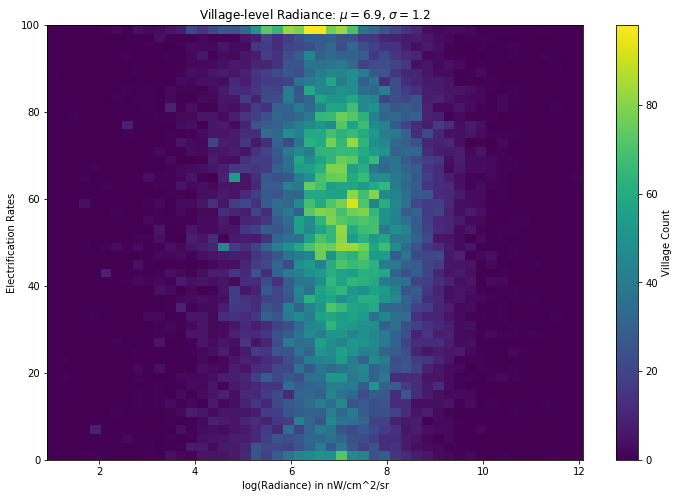

In [26]:
# a 2D histogram version of above data

from matplotlib.colors import LogNorm
import pylab

x = np.log(df_merged['TNL'])
y = df_merged['Percentage Electrified_x']

mu = np.mean(x)
sigma = np.std(x)

plt.figure(figsize=(12,8))
#plt.hist2d(x, y, bins=52, norm=LogNorm())
plt.hist2d(x, y, bins=(50, 50))
plt.colorbar().set_label('Village Count')
pylab.ylim([y.min(),y.max()])
#pylab.xlim([x.min(),x.max()])
plt.xlabel('log(Radiance) in nW/cm^2/sr')
plt.ylabel('Electrification Rates')
plt.title('Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))
plt.show()

In [8]:
df_merged = pd.read_csv('bihar_features_gee.csv')


df_merged['Percentage Electrified_x'] = df_merged['eH']/df_merged['HH']*100
df_merged.head()


df_merged = df_merged.replace(-9, np.nan)
# for some reason the Census 2011 ID column was reading in as a float w/ a ".0" at the tail of
# each village so the next line is to drop the ".0"
#df['Census 2011 ID'] = df['Census 2011 ID'].astype(str).str[:-2]
#df['Percentage Electrified'] = (df['Number of Electrified Households']/df['Number of Households'])*100
#df['Census 2011 ID'] = df['Census 2011 ID'].str.split('.')[0]
#df['NL per Household'] = (df['TNL']/df['Number of Households'])*100
df_merged = df_merged.dropna(axis=0, how='any') 
df_merged[~df_merged.index.duplicated(keep=False)]
df_merged = df_merged.copy()
df_merged.head()


,CEN_2011,NAME,eH,HH,01VIIRS_10th,02VIIRS_10th,03VIIRS_10th,04VIIRS_10th,05VIIRS_10th,06VIIRS_10th,...,B1_STD_DEV,B10_STD_DEV,B11_STD_DEV,B2_STD_DEV,B3_STD_DEV,B4_STD_DEV,B5_STD_DEV,B6_STD_DEV,B7_STD_DEV,Percentage Electrified_x
2,215991,Tharhi,214.0,339.0,0.043099,0.077040,0.170996,0.179324,0.291569,0.161928,...,0.023320,0.001737,0.001726,0.027221,0.034742,0.043921,0.086157,0.054006,0.043298,63.126844
3,215992,Pipra,59.0,107.0,0.419949,0.381883,0.491086,0.876705,0.542789,0.226300,...,0.012286,0.001196,0.001456,0.013462,0.018037,0.019069,0.087061,0.042743,0.023066,55.140187
4,215993,Kotaraha,64.0,128.0,0.204294,0.180164,0.262577,0.376620,0.400297,0.227038,...,0.012365,0.001090,0.001329,0.012730,0.016276,0.017785,0.079940,0.036686,0.019230,50.000000
5,215994,Rampurwa,118.0,726.0,0.227341,0.208226,0.287490,0.129210,0.462042,0.244227,...,0.012508,0.001505,0.001741,0.014410,0.019388,0.022390,0.075418,0.038113,0.028459,16.253444
6,215995,Lachhmipur,449.0,615.0,0.184173,0.188419,0.242215,0.190012,0.365727,0.189305,...,0.008256,0.000851,0.001157,0.008430,0.013690,0.013010,0.073827,0.033603,0.016145,73.008130


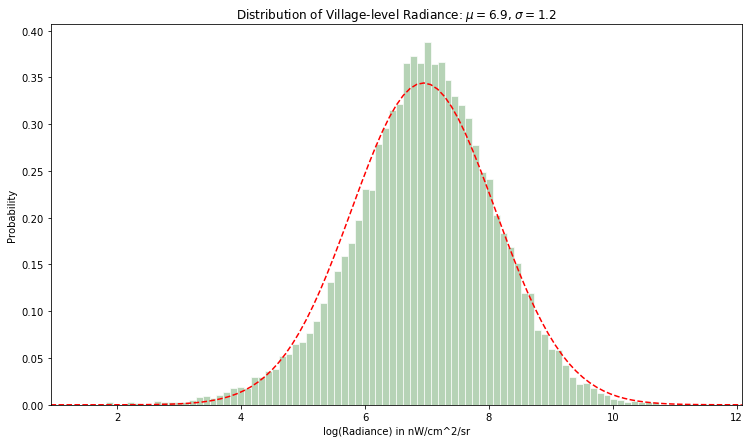

In [27]:
### log-transformed distribution of radiance values
import matplotlib.mlab as mlab



x = np.log(df_merged['TNL'])
num_bins = 100
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='darkseagreen', alpha=0.65, edgecolor=(1,1,1))

### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('log(Radiance) in nW/cm^2/sr')
plt.ylabel('Probability')
plt.title('Distribution of Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

In [38]:
### log-transformed distribution of radiance values
import matplotlib.mlab as mlab
from matplotlib.colors import LogNorm
import pylab

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['08VIIRS_MED'])
x2 = np.log(df_gt['08VIIRS_MED'])

# x = (df_lt['02VIIRS_90th'])
# x2 = (df_gt['02VIIRS_90th'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Total Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


ValueError: max must be larger than min in range parameter.

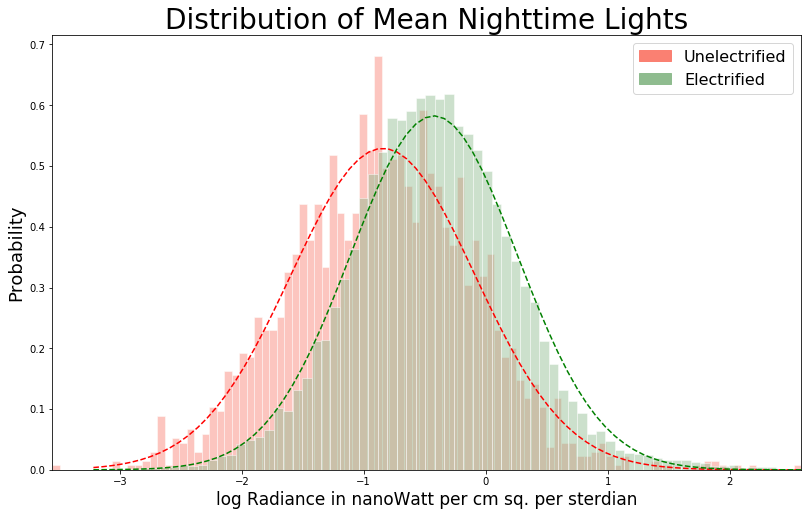

In [36]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['Mean'])
x2 = np.log(df_gt['Mean'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Mean Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

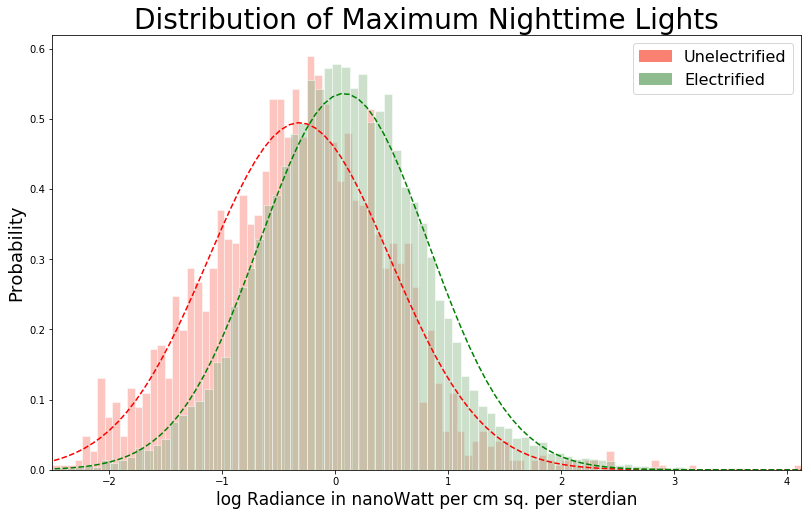

In [42]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['Max'])
x2 = np.log(df_gt['Max'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Maximum Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

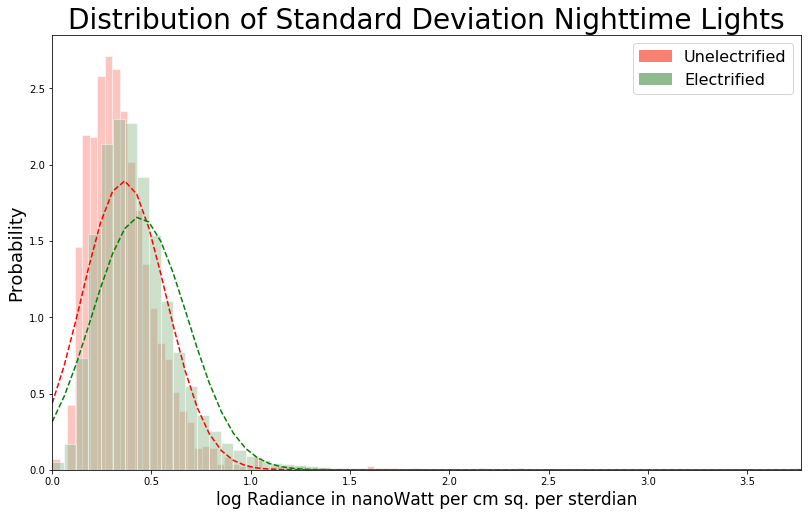

In [63]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.sqrt(df_lt['Standard Deviation'])
x2 = np.sqrt(df_gt['Standard Deviation'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Standard Deviation Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

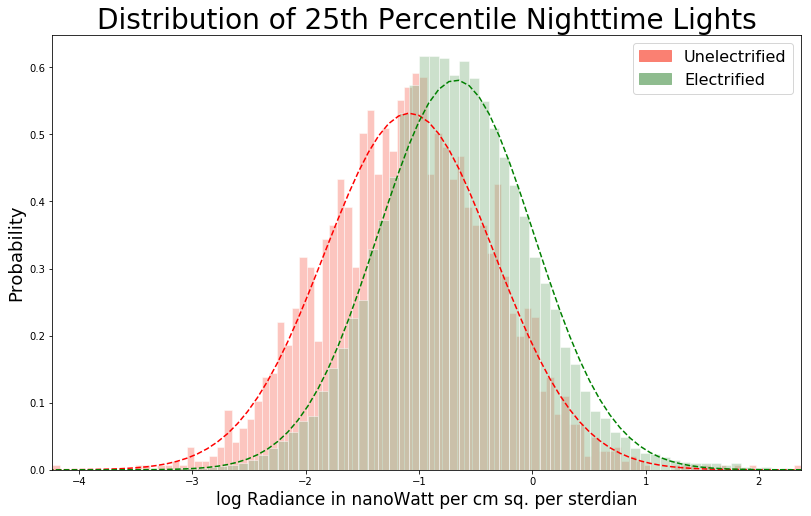

In [68]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['25th Percentile'])
x2 = np.log(df_gt['25th Percentile'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of 25th Percentile Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

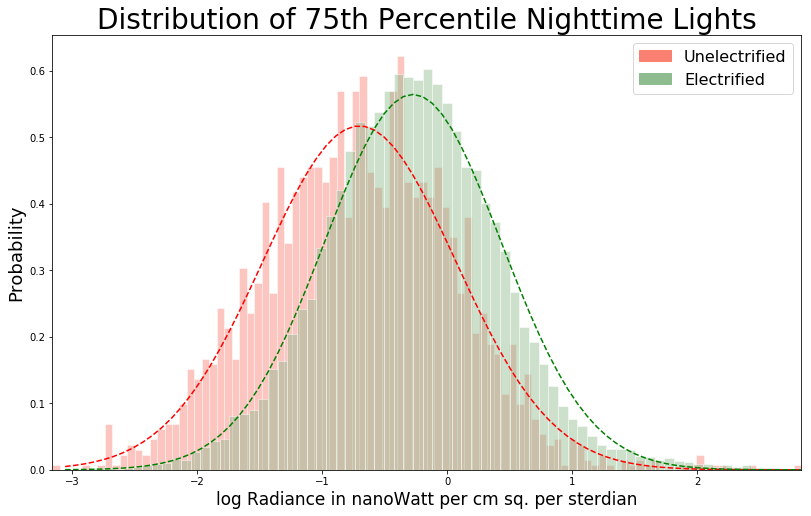

In [69]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['75th Percentile'])
x2 = np.log(df_gt['75th Percentile'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of 75th Percentile Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

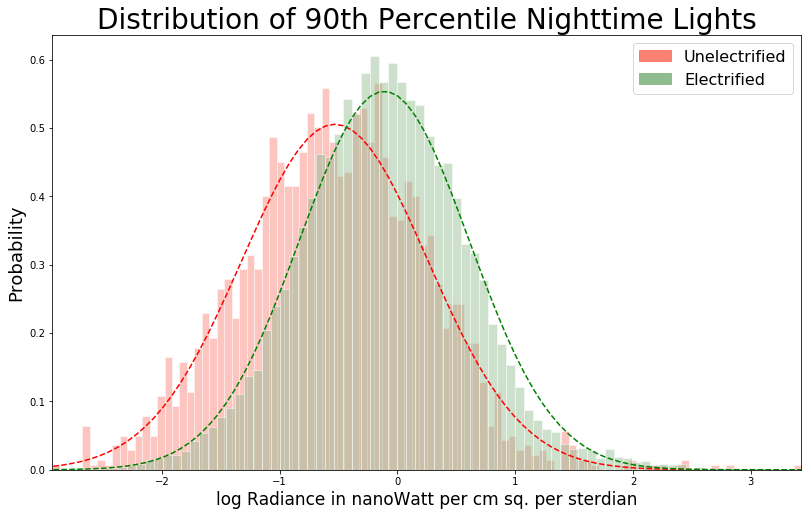

In [66]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['90th Percentile'])
x2 = np.log(df_gt['90th Percentile'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of 90th Percentile Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

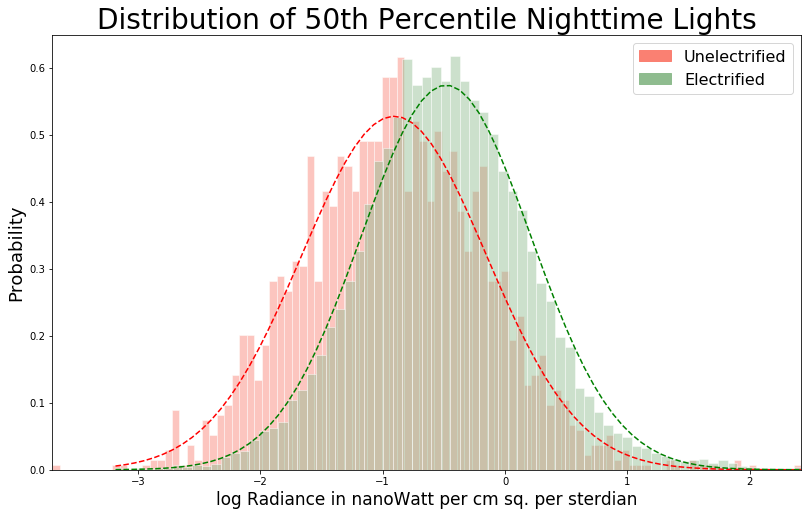

In [83]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['50th Percentile'])
x2 = np.log(df_gt['50th Percentile'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2, num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of 50th Percentile Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


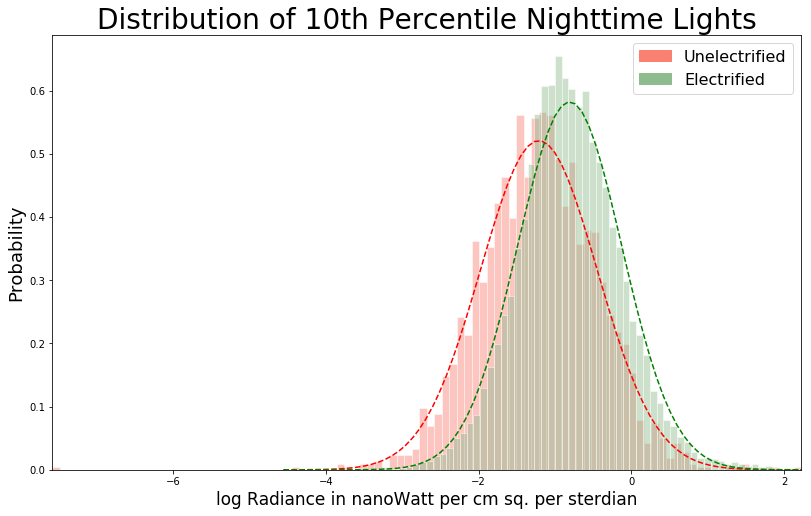

In [88]:
### log-transformed distribution of radiance values

df_lt = df_merged[df_merged['Percentage Electrified_x'] <= 10 ]
df_gt = df_merged[df_merged['Percentage Electrified_x'] > 10 ]
# df_lt.head()

x = np.log(df_lt['10th Percentile'])
x2 = np.log(df_gt['10th Percentile'])
num_bins = 100
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x.dropna(), num_bins, normed=1, facecolor='salmon', alpha=0.45, edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2.dropna(), num_bins, normed=1, facecolor='darkseagreen', alpha=0.45, edgecolor=(1,1,1))
### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)
mu2 = np.mean(x2)
sigma2 = np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('log Radiance in nanoWatt per cm sq. per sterdian', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of 10th Percentile Nighttime Lights', fontsize=28)# - Unelectrified $\mu={:0.2}$, $\sigma={:0.2}$; Electrified $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma, mu2, sigma2))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='salmon', label='Unelectrified')
green_patch = mpatches.Patch(color='darkseagreen', label='Electrified')
plt.legend(handles=[red_patch, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

In [ ]:
# Mean                                  33315
# Max                                   33315
# Standard Deviation                    33315
# TNL                                   33315
# 10th Percentile                       33315
# 25th Percentile                       33315
# 50th Percentile                       33315
# 75th Percentile                       33315
# 90th Percentile                       33315